### Check downloaded videos

In [9]:
# check how many subfolders are in the folder training, and check how many videos are in each subfolder

import os
import json

def check_subfolders(path, save_seen_labels=False):

    print('\nChecking subfolders in path: ' + path)

    subfolders = [f.path for f in os.scandir(path) if f.is_dir()]
    print('Number of subfolders: ' + str(len(subfolders)), 'in path: ' + path)

    # if no subfolders, count how many videos are in the folder
    if len(subfolders) == 0:
        files = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
        files_ct = len(files)
        print('Number of videos: ' + str(files_ct))
        return

    class_ct = dict()
    total_videos_ct = 0
    for subfolder in subfolders:
        
        # count number of videos in each subfolder
        files = [f for f in os.listdir(subfolder) if os.path.isfile(os.path.join(subfolder, f))]
        files_ct = len(files)
        total_videos_ct += files_ct
        class_ct[subfolder] = files_ct
    
    # sort class_ct by value
    class_ct = {k: v for k, v in sorted(class_ct.items(), key=lambda item: item[1], reverse=True)}

    # print top5 and bottom5 classes
    print('Top 5 classes:')
    for i, (k, v) in enumerate(class_ct.items()):
        if i < 5:
            print(k, v)
    print('Bottom 5 classes:')
    for i, (k, v) in enumerate(class_ct.items()):
        if i > len(class_ct) - 6:
            print(k, v)

    print('Number of total videos: ' + str(total_videos_ct))

    # pick the least frequent 50 classes as unseen classes, the rest as seen classes, save the class index to json files
    if save_seen_labels:

        # load output/anet_label_to_idx.json
        with open('output/anet_label_to_index.json', 'r') as f:
            label_to_idx = json.load(f)

        seen_label = dict()
        seen_idx = set()
        unseen_label = dict()
        unseen_idx = set()

        for i, (k, v) in enumerate(class_ct.items()): # this is ordered from most to least frequent
            # replace the _ in k with space
            k = k.split('/')[-1].replace('_', ' ')
            if i < 150:
                seen_label[k] = v
                index = label_to_idx[k]
                seen_idx.add(index)
            else:
                unseen_label[k] = v
                index = label_to_idx[k]
                unseen_idx.add(index)

        # save seen_label and unseen_label, seen_idx and unseen_idx to json files
        with open('output/seen_labels.json', 'w') as f:
            json.dump(seen_label, f, indent=4)
        
        with open('output/unseen_labels.json', 'w') as f:
            json.dump(unseen_label, f, indent=4)
        
        with open('output/seen_idx.json', 'w') as f:
            json.dump(list(seen_idx), f, indent=4)
        
        with open('output/unseen_idx.json', 'w') as f:
            json.dump(list(unseen_idx), f, indent=4)
    
    return class_ct

    
train_class_ct = check_subfolders('../data/ActivityNet_200/training', True)
check_subfolders('../data/ActivityNet_200/validation')
check_subfolders('../data/ActivityNet_200/testing')


Checking subfolders in path: ../data/ActivityNet_200/training
Number of subfolders: 200 in path: ../data/ActivityNet_200/training
Top 5 classes:
../data/ActivityNet_200/training/Playing_congas 72
../data/ActivityNet_200/training/Surfing 63
../data/ActivityNet_200/training/Using_parallel_bars 62
../data/ActivityNet_200/training/Using_the_balance_beam 60
../data/ActivityNet_200/training/Playing_drums 58
Bottom 5 classes:
../data/ActivityNet_200/training/Painting_furniture 20
../data/ActivityNet_200/training/Bathing_dog 19
../data/ActivityNet_200/training/Smoking_a_cigarette 19
../data/ActivityNet_200/training/Drinking_beer 19
../data/ActivityNet_200/training/Bullfighting 16
Number of total videos: 7457

Checking subfolders in path: ../data/ActivityNet_200/validation
Number of subfolders: 200 in path: ../data/ActivityNet_200/validation
Top 5 classes:
../data/ActivityNet_200/validation/Playing_congas 34
../data/ActivityNet_200/validation/Surfing 33
../data/ActivityNet_200/validation/Playi

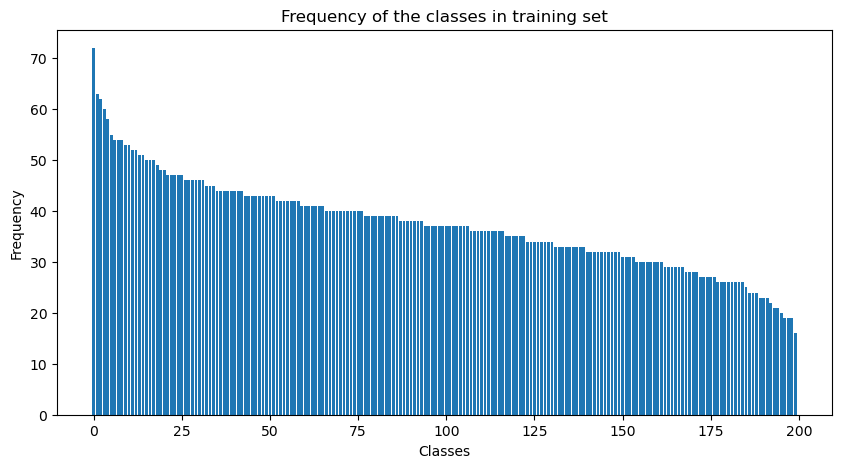

In [11]:
# plot the frequency of the classes
import matplotlib.pyplot as plt
import numpy as np

# plot barchart of the frequency of the classes, x is number from 0 to 199, y is the frequency

x= []
y = []
for i, (k, v) in enumerate(train_class_ct.items()):
    x.append(i)
    y.append(v)

plt.figure(figsize=(10, 5))
plt.bar(x, y)
plt.xlabel('Classes')
plt.ylabel('Frequency')
plt.title('Frequency of the classes in training set')
plt.show()


### Sample videos 

* sample 3 videos in the training and validation folder for testing with CLIP
* copy the sampled videos to data/ActivityNet_200_sampled/

In [7]:
from tqdm import tqdm
import json
import os

def sample_videos(src_path, dst_path, mode, n_sample = 3):

    print('\nSampling videos from path: ' + src_path)

    # randomly sample 3 videos from each subfolder in src_path, and copy them to dst_path
    subfolders = [f.path for f in os.scandir(src_path) if f.is_dir()]

    src_files = []
    dst_files = []
    for subfolder in subfolders:
        dst_subfolder = dst_path + '/' + subfolder.split('/')[-1]
        files = [f for f in os.listdir(subfolder) if os.path.isfile(os.path.join(subfolder, f))]
        #print(files[0])
        files_ct = len(files)
        if files_ct < n_sample:
            # add all videos' full path in the subfolder to src_files
            for i in range(files_ct):
                src_files.append(subfolder + '/' + files[i])
                dst_files.append(dst_subfolder + '/' + files[i])
        else:            
            for i in range(n_sample): # select the first n_sample videos
                src_files.append(subfolder + '/' + files[i])
                dst_files.append(dst_subfolder + '/' + files[i])
    
    # save the src_files and dst_files to json files    
    with open('output/' + mode + '_src_files.json', 'w') as f:
        json.dump(src_files, f, indent=4)

    with open('output/' + mode + '_dst_files.json', 'w') as f:
        json.dump(dst_files, f, indent=4)

    print(src_files[0])
    print(dst_files[0])
    
    # copy videos from src_files to dst_path
    for src_file, dst_file in tqdm(zip(src_files, dst_files)):
        if not os.path.exists(os.path.dirname(dst_file)):
            os.makedirs(os.path.dirname(dst_file))
            #print('create folder: ' + os.path.dirname(dst_file))
            
        os.system('cp ' + src_file + ' ' + dst_file)

In [ ]:
sample_videos('../data/ActivityNet_200/training', '../data/ActivityNet_200_sampled/training', 'training')

In [8]:
sample_videos('../data/ActivityNet_200/validation', '../data/ActivityNet_200_sampled/validation', 'validation')


Sampling videos from path: ../data/ActivityNet_200/validation
../data/ActivityNet_200/validation/Croquet/gSH5ya0pfko.mp4
../data/ActivityNet_200_sampled/validation/Croquet/gSH5ya0pfko.mp4


13it [00:17,  2.49s/it]

In [17]:
# check how many videos are in each subfolder
check_subfolders('../data/ActivityNet_200_sampled/training')
check_subfolders('../data/ActivityNet_200_sampled/validation')


Checking subfolders in path: ../data/ActivityNet_200_sampled/training
Number of subfolders: 200 in path: ../data/ActivityNet_200_sampled/training
Top 5 classes:
../data/ActivityNet_200_sampled/training/Croquet 3
../data/ActivityNet_200_sampled/training/Putting_on_makeup 3
../data/ActivityNet_200_sampled/training/Preparing_salad 3
../data/ActivityNet_200_sampled/training/Clean_and_jerk 3
../data/ActivityNet_200_sampled/training/Archery 3
Bottom 5 classes:
../data/ActivityNet_200_sampled/training/Fixing_the_roof 3
../data/ActivityNet_200_sampled/training/Futsal 3
../data/ActivityNet_200_sampled/training/Cleaning_windows 3
../data/ActivityNet_200_sampled/training/Gargling_mouthwash 3
../data/ActivityNet_200_sampled/training/Curling 3
Number of total videos: 600

Checking subfolders in path: ../data/ActivityNet_200_sampled/validation
Number of subfolders: 200 in path: ../data/ActivityNet_200_sampled/validation
Top 5 classes:
../data/ActivityNet_200_sampled/validation/Shot_put 4
../data/Ac

### xxx Resize sampled videos
* No need to resize the videos if not loading videos directly, because the frames are resized when slicing the frames
* resize sampled videos to short edge = 256 pixels

In [15]:
# Use FFmpeg to rescale the videos to short edge =256 pixels
#!python video_resize.py ROOT_PATH OUT_PATH --level 2 -se 256

# !python video_resize.py ../data/ActivityNet_200_sampled/training ../data/ActivityNet_200_sampled/training_resized256 --level 2 -se 256

src_list: ['../data/ActivityNet_200_sampled/training/Croquet/8WFB_LUOx4k.mp4', '../data/ActivityNet_200_sampled/training/Croquet/l-YtPYZ_534.mp4', '../data/ActivityNet_200_sampled/training/Croquet/ctFlPn4EfkU.mp4', '../data/ActivityNet_200_sampled/training/Putting_on_makeup/1Y1pKGFm-pQ.mp4', '../data/ActivityNet_200_sampled/training/Putting_on_makeup/rdszlTqxBXs.mp4', '../data/ActivityNet_200_sampled/training/Putting_on_makeup/InA8Xbg-hvo.mp4', '../data/ActivityNet_200_sampled/training/Preparing_salad/tnavaGow7BI.mp4', '../data/ActivityNet_200_sampled/training/Preparing_salad/XEqijKYIJNg.mp4', '../data/ActivityNet_200_sampled/training/Preparing_salad/rX2tRvv2ZfU.mp4', '../data/ActivityNet_200_sampled/training/Clean_and_jerk/MldEr60j33M.mp4', '../data/ActivityNet_200_sampled/training/Clean_and_jerk/blCvgADz8LY.mp4', '../data/ActivityNet_200_sampled/training/Clean_and_jerk/8TDYCXqSHCw.mp4', '../data/ActivityNet_200_sampled/training/Archery/1o9RGnujlkI.mp4', '../data/ActivityNet_200_sampl

In [ ]:
# !python video_resize.py ../data/ActivityNet_200_sampled/validation ../data/ActivityNet_200_sampled/validation_resized256 --level 2 -se 256

### Extract raw frames
* extract frames into images
* run the following 2 commands in terminal
  * extract frames at fps=1, resize the frames to 256x340, and save them to a new folder
  * `python video2image.py ../data/ActivityNet_200_sampled/training ../data/ActivityNet_200_sampled/training_resize256x340_fps1 --level 2 --lib ffmpeg -fps 1`
  * `python video2image.py ../data/ActivityNet_200_sampled/validation ../data/ActivityNet_200_sampled/validation_resize256x340_fps1 --level 2 --lib ffmpeg -fps 1`

### Prepare annotations

In [5]:
# prepare the index-label mapping file based on anet1.3_labels.csv
import json
import pandas as pd

# laod anet1.3_labels.csv, and create a dictionary mapping label to index, first column is index, second column is label
df = pd.read_csv('anet1.3_labels.csv')
print('df.shape: ', df.shape)
print('df.head(): ', df.head())

# create a dictionary mapping label to index
label_to_index = dict()
index_to_label = dict()
for i in range(df.shape[0]):
    label_to_index[df.iloc[i, 1]] = str(df.iloc[i, 0])
    index_to_label[str(df.iloc[i, 0])] = df.iloc[i, 1]

print('label_to_index: ', label_to_index)
print('index_to_label: ', index_to_label)

# save the dictionary to json file
with open('output/anet_label_to_index.json', 'w') as f:
    json.dump(label_to_index, f, indent=4)

with open('output/anet_index_to_label.json', 'w') as f:
    json.dump(index_to_label, f, indent=4)

df.shape:  (200, 2)
df.head():     id                name
0   0  Applying sunscreen
1   1             Archery
2   2       Arm wrestling
3   3  Assembling bicycle
4   4                 BMX
label_to_index:  {'Applying sunscreen': '0', 'Archery': '1', 'Arm wrestling': '2', 'Assembling bicycle': '3', 'BMX': '4', 'Baking cookies': '5', 'Ballet': '6', 'Bathing dog': '7', 'Baton twirling': '8', 'Beach soccer': '9', 'Beer pong': '10', 'Belly dance': '11', 'Blow-drying hair': '12', 'Blowing leaves': '13', 'Braiding hair': '14', 'Breakdancing': '15', 'Brushing hair': '16', 'Brushing teeth': '17', 'Building sandcastles': '18', 'Bullfighting': '19', 'Bungee jumping': '20', 'Calf roping': '21', 'Camel ride': '22', 'Canoeing': '23', 'Capoeira': '24', 'Carving jack-o-lanterns': '25', 'Changing car wheel': '26', 'Cheerleading': '27', 'Chopping wood': '28', 'Clean and jerk': '29', 'Cleaning shoes': '30', 'Cleaning sink': '31', 'Cleaning windows': '32', 'Clipping cat claws': '33', 'Cricket': '34', 'Croq

In [4]:
import json
import os
from tqdm import tqdm

def gen_label_file(video_root, label_index_file, out_file):
    """Generate label file for each video
    """
    
    with open(label_index_file, 'r') as f:
        label_to_index = json.load(f)
    print('label_to_index: ', label_to_index)

    # get a list of subfolders in video_root
    subfolders = [f.path for f in os.scandir(video_root) if f.is_dir()]
    print('subfolders: ', subfolders)
    print('len(subfolders): ', len(subfolders))

    # loop through each subfolder/class, get the list of subfolders within each subfolder/class
    path_frmct_label = []    
    for subfolder in tqdm(subfolders):
        folder_name = subfolder.split('/')[-1]
        #print('folder_name: ', folder_name)
        class_name = ' '.join(folder_name.split('_'))
        #print('class_name: ', class_name)
        class_index = label_to_index[class_name]
        #print('class_index: ', class_index)
        video_list = [f.path for f in os.scandir(subfolder) if f.is_dir()]
        #print('video_list: ', video_list)

        # loop through each video in the video_list, count number of frames in each video, and write to out_file
        for video in video_list:
            frames = [f.path for f in os.scandir(video) if f.is_file()]
            frames_ct = len(frames)
            video_id = video.split('/')[-1]
            #print('video_id: ', video_id)
            video_path = folder_name + '/' + video_id
            #print('video_path: ', video_path)

            # some videos has 0 frames, skip them
            if frames_ct == 0:
                print('Warning: frames_ct == 0, video_path: {}, class_index: {}'.format(video_path, class_index))
                continue

            line = "{} {} {}\n".format(video_path, frames_ct, class_index)
            path_frmct_label.append(line)

            #stop
        
    with open(out_file, 'w') as f:
        content = ''.join(path_frmct_label)
        f.write(content)


In [ ]:
gen_label_file('../data/ActivityNet_200_sampled/training_resize256x340_fps1', 'output/anet_label_to_index.json', 'output/anet_sampled_training_zeroshot.txt')

In [5]:
gen_label_file('../data/ActivityNet_200_sampled/validation_resize256x340_fps1', 'output/anet_label_to_index.json', 'output/anet_sampled_validation_zeroshot.txt')

label_to_index:  {'Applying sunscreen': '0', 'Archery': '1', 'Arm wrestling': '2', 'Assembling bicycle': '3', 'BMX': '4', 'Baking cookies': '5', 'Ballet': '6', 'Bathing dog': '7', 'Baton twirling': '8', 'Beach soccer': '9', 'Beer pong': '10', 'Belly dance': '11', 'Blow-drying hair': '12', 'Blowing leaves': '13', 'Braiding hair': '14', 'Breakdancing': '15', 'Brushing hair': '16', 'Brushing teeth': '17', 'Building sandcastles': '18', 'Bullfighting': '19', 'Bungee jumping': '20', 'Calf roping': '21', 'Camel ride': '22', 'Canoeing': '23', 'Capoeira': '24', 'Carving jack-o-lanterns': '25', 'Changing car wheel': '26', 'Cheerleading': '27', 'Chopping wood': '28', 'Clean and jerk': '29', 'Cleaning shoes': '30', 'Cleaning sink': '31', 'Cleaning windows': '32', 'Clipping cat claws': '33', 'Cricket': '34', 'Croquet': '35', 'Cumbia': '36', 'Curling': '37', 'Cutting the grass': '38', 'Decorating the Christmas tree': '39', 'Disc dog': '40', 'Discus throw': '41', 'Dodgeball': '42', 'Doing a powerbomb

100%|██████████| 200/200 [02:27<00:00,  1.36it/s]


In [ ]:
# !python gen_label.py VIDEO_ROOT kinetics400 --phase train  --level 2 --source video